In [5]:
import osmnx as ox
import networkx as nx
import numpy as np

In [3]:
folderoots = "../data/processed/plan_paris/ignored_growth/pruned_paris_multigraph/"

In [4]:
G = ox.load_graphml(
    "../data/processed/plan_paris/paris_bikeplan_pruned_multigraph.graphml"
)
for e in G.edges:
    G.edges[e]["built"] = int(G.edges[e]["built"])
BUFF_SIZE = 350

In [27]:
def closest(lst, K):
    lst = np.asarray(lst)
    idx = (np.abs(lst - K)).argmin()
    return idx, lst[idx]

In [52]:
def get_subtractive_invalid_edges(G, built=True):
    """
    Find all invalid edges that if removed would create a new, unacceptable component to the graph. A new component is unacceptable if it's not a subgraph of a component that is part of the built graph but not of the actual graph.

    Args:
        G (networkx.Graph): Graph on which we want to remove edges.
        built (bool, optional): If True, there is a built component to the graph to take into account. This is represented by an edge attribute on all edges, that is 1 if it's built, 0 if it's not built. Defaults to True.

    Returns:
        list: List of tuple, each tuple being an invalid edge to remove from G.
    """
    # Find all bridges and remove bridges that when removed leave an isolated node
    invalid_edges = [
        edge
        for edge in nx.bridges(G)
        if not any(nx.degree(G, node) == 1 for node in edge[:2])
    ]
    # If there are elected nodes there are built edges that we can't remove
    if built:
        built_edges = [edge for edge in G.edges if G.edges[edge]["built"] == 1]
        invalid_edges += built_edges
        invalid_edges = set(invalid_edges)
        elected_nodes = elect_nodes(G.edge_subgraph(built_edges))
    # Sanity check
    if nx.number_connected_components(G) > len(elected_nodes):
        raise ValueError("Issue with number of component computed")
    # If built is False work stops before checking elected_nodes, if built is True elected_nodes is created so it works
    if built is False or nx.number_connected_components(G) == len(elected_nodes):
        return invalid_edges
    # New component can be created only if part of a new component with a built part
    else:
        updated_invalid_edges = invalid_edges.copy()
        for edge in invalid_edges:
            if edge not in built_edges:
                H = G.copy()
                H.remove_edge(*edge)
                # Accept edges (remove from invalid edges) that if removed from the graph create a new component with a built part
                if not any(
                    not any(node in cc for node in elected_nodes)
                    for cc in list(nx.connected_components(H))
                ):
                    updated_invalid_edges.remove(edge)
        return updated_invalid_edges


def get_additive_invalid_edges(G_actual, G_final):
    """
    Find all invalid edges that if added would create a new, unacceptable component to the graph. A new component is unacceptable if it's not a subgraph of a component that is part of the final graph but not of the actual graph.

    Args:
        G_actual (networkx.Graph): Graph on which we want to add edges.
        G_final (networkx.Graph): Final graph, from where we find potential edges that can be added to the actual graph.

    Returns:
        list: List of tuple, each tuple being an invalid edge to add to G_actual from G_final.
    """
    invalid_edges = [
        edge
        for edge in G_final.edges
        if (not any(node in G_actual for node in edge[:2])) or edge in G_actual.edges
    ]
    # If already the final number of cc or will connect in the future give list of adjacent edge only
    if nx.number_connected_components(G_actual) >= nx.number_connected_components(
        G_final
    ):
        return invalid_edges
    # Else a new component can be created, but need to be within a final component not already on the graph
    else:
        updated_invalid_edges = invalid_edges.copy()
        for edge in invalid_edges:
            new_edges = list(G_actual.edges)
            # Graph.edge_subgraph can only use list of tuple, not list of list
            new_edges.append(tuple(edge))
            H = G_final.edge_subgraph(new_edges)
            # Accept edges (remove from invalid edges) that if added to the graph create a new component that is a subgraph of a component of the final graph
            if not any(
                not any(node in cc for node in elect_nodes(H))
                for cc in list(nx.connected_components(G_final))
            ):
                updated_invalid_edges.remove(edge)
        return updated_invalid_edges


def elect_nodes(G):
    """Take one node from each components of G to represent them."""
    return [next(iter(cc)) for cc in list(nx.connected_components(G))]

In [53]:
def _valid_edges(G, G_actual, init_edges, built, keep_connected, order):
    """Return the valid edges to add or remove for the next step of the growth of G from G_actual."""
    # If connectedness constraint remove invalid edges that would add unacceptable new component
    if keep_connected:
        if order == "subtractive":
            invalid_edges = get_subtractive_invalid_edges(G_actual, built=built)
            return [edge for edge in G_actual.edges if edge not in invalid_edges]
        elif order == "additive":
            invalid_edges = get_additive_invalid_edges(G_actual, G)
            return [edge for edge in G.edges if edge not in invalid_edges]
    else:
        if order == "subtractive":
            return [edge for edge in G_actual.edges if edge not in init_edges]
        elif order == "additive":
            return [edge for edge in G.edges if edge not in G_actual.edges]

In [54]:
def _init_edges(G, built, order):
    """Return the initial edges for the first step of the growth of G."""
    if built:
        init_edges = [edge for edge in G.edges if G.edges[edge]["built"] == 1]
        return init_edges
    # If no built part, start from a seed being a random edge from the node with the highest closeness
    else:
        # If subtractive, don't care about finding an initial edge because will be found through optimization, dummy variable
        if order == "subtractive":
            return [0]
        # If additive, use as initial edge if none given the one with the highest average closeness of its nodes
        elif order == "additive":
            closeness = nx.closeness_centrality(G, distance="length")
            edge_closeness = {}
            for edge in G.edges:
                edge_closeness[edge] = (closeness[edge[0]] + closeness[edge[1]]) / 2
            return [tuple(max(edge_closeness, key=edge_closeness.get))]

In [55]:
def _init_graph(G, order, init_edges):
    """Return the initial graph for the growth depending on the order."""
    if order == "subtractive":
        return G.copy()
    elif order == "additive":
        return G.edge_subgraph(init_edges)

In [56]:
G = ox.load_graphml(
    "../data/processed/plan_paris/paris_bikeplan_pruned_multigraph.graphml"
)
for e in G.edges:
    G.edges[e]["built"] = int(G.edges[e]["built"])

In [57]:
len(G)

355

In [58]:
built_edges = [edge for edge in G.edges if G.edges[edge]["built"] == 1]

In [ ]:
tested_edge = built_edges
tested_edge.append(())

In [ ]:
G_tested = _init_graph(G, "additive", built_edges)

In [ ]:
G_tested.add_edge_from()

In [ ]:
# add_valid_edges = _valid_edges(G, G_init, init_edges=built_edges, built=True, keep_connected=True, order="subtractive")

In [66]:
gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

In [71]:
# color = []
# for edge in G.edges:
#     if edge in built_edges:
#         color.append("black")
#     elif edge in add_valid_edges:
#         color.append("green")
#     else:
#         color.append("red")
# gdf["color"] = color

<Axes: >

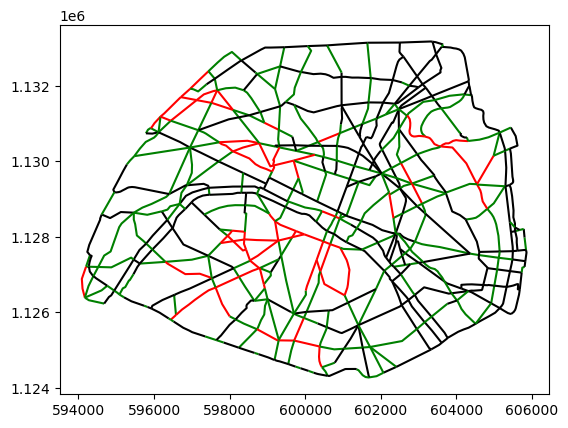

In [72]:
gdf.plot(color=gdf["color"])